# Feature Importance

In [1]:
using Flux
using BSON: @load
using Chemfiles
using Plots
using Statistics
using StatsBase
using Clustering
using LinearAlgebra


"""
Структура для хранения параметров функции G2
"""
struct G2
    eta::Float64      # Параметр ширины гауссиана
    rcutoff::Float64  # Радиус обрезания
    rshift::Float64   # Сдвиг центра гауссиана
    norm::Float64     # Нормировочный коэффициент
end

# Функции для геометрического анализа
"""
Строит матрицу расстояний между всеми атомами во фрейме
"""
function build_distance_matrix(frame)
    N = length(frame)
    return [distance(frame, i - 1, j - 1) for i = 1:N, j = 1:N]
end

"""
Вычисляет функцию обрезания для заданного расстояния
"""
function distance_cutoff(d::Float64, rcutoff::Float64 = 10.0)
    return d > rcutoff ? 0.0 : 0.5 * (cos(π * d / rcutoff) + 1.0)
end

"""
Вычисляет значение G2 функции для заданного набора расстояний
"""
function compute_g2(distances, eta, rcutoff, rshift, norm)
    return sum(
        exp(-eta * (d - rshift)^2) * distance_cutoff(d, rcutoff) for
        d in distances if d > 0.0
    ) / norm
end

"""
Строит матрицу G2 значений для всех атомов и G2 функций
"""
function build_g2_matrix(distance_matrix, g2_functions)
    N = size(distance_matrix, 1)
    g2_matrix = zeros(Float64, N, length(g2_functions))

    for i = 1:N
        distances = distance_matrix[i, :]
        for (j, g2_func) in enumerate(g2_functions)
            g2_matrix[i, j] = compute_g2(
                distances,
                g2_func.eta,
                g2_func.rcutoff,
                g2_func.rshift,
                g2_func.norm,
            )
        end
    end
    return g2_matrix
end

"""
Вычисляет среднюю G2 матрицу и сохраняет все G2 матрицы по траектории
"""
function compute_average_g2_matrix(trajectory_path, g2_functions)
    trajectory = Trajectory(trajectory_path)
    nframes = length(trajectory)

    # Читаем первый фрейм для определения размерности
    frame = read(trajectory)
    distance_mat = build_distance_matrix(frame)
    g2_mat = build_g2_matrix(distance_mat, g2_functions)

    # Инициализируем массивы для хранения всех G2 матриц
    avg_g2_mat = zeros(size(g2_mat))
    all_g2_matrices = Vector{typeof(g2_mat)}(undef, nframes)
    all_g2_matrices[1] = g2_mat

    # Обрабатываем все фреймы
    for i = 2:nframes
        frame = read(trajectory)
        distance_mat = build_distance_matrix(frame)
        g2_mat = build_g2_matrix(distance_mat, g2_functions)
        all_g2_matrices[i] = g2_mat
        avg_g2_mat .+= g2_mat
    end

    close(trajectory)
    return avg_g2_mat ./ nframes, all_g2_matrices
end

"""
Анализирует важность признаков путем их обнуления
"""
function analyze_feature_importance(model, reference_input)
    e_reference = model(reference_input)
    errors = zeros(length(reference_input))

    for n_g2 = 1:length(reference_input)
        tmp_input = copy(reference_input)
        tmp_input[n_g2] = 0
        e_tmp = model(tmp_input)
        error = abs(e_reference[1] - e_tmp[1]) / abs(e_reference[1]) * 100
        errors[n_g2] = error
        println("Feature: $n_g2, Relative Error: $(round(error, digits=2))%")
    end

    return errors
end

"""
Анализирует корреляции между G2 функциями
"""
function analyze_g2_correlations(avg_g2_mat)
    # Вычисляем корреляционную матрицу
    cor_matrix = cor(avg_g2_mat)

    # Находим сильно коррелирующие пары
    n_features = size(cor_matrix, 1)
    strong_correlations = []

    for i = 1:n_features
        for j = (i+1):n_features
            if abs(cor_matrix[i, j]) > 0.9  # Порог корреляции
                push!(strong_correlations, (i, j, cor_matrix[i, j]))
            end
        end
    end

    # Выводим результаты
    println("\nСильно коррелирующие G2 функции (|r| > 0.9):")
    for (i, j, r) in strong_correlations
        println("G2_$i - G2_$j: r = $(round(r, digits=3))")
    end

    return cor_matrix, strong_correlations
end

"""
Анализирует распределение G2 значений по траектории
"""
function analyze_g2_distribution(all_g2_matrices)
    n_atoms, n_features = size(all_g2_matrices[1])
    n_frames = length(all_g2_matrices)

    # Инициализируем массивы для статистик
    means = zeros(n_features)
    stds = zeros(n_features)
    quartiles = zeros(3, n_features)

    # Для каждой G2 функции
    for j = 1:n_features
        # Собираем все значения по фреймам и атомам
        values = Float64[]
        for frame in all_g2_matrices
            append!(values, frame[:, j])
        end

        # Вычисляем статистики
        means[j] = mean(values)
        stds[j] = std(values)
        quartiles[:, j] = quantile(values, [0.25, 0.5, 0.75])
    end

    return means, stds, quartiles
end

# Визуализация

"""
Визуализирует тепловую карту G2 матрицы
"""
function plot_g2_heatmap(avg_g2_mat)
    heatmap(
        avg_g2_mat,
        title = "Average G2 Matrix",
        xlabel = "G2 Function Index",
        ylabel = "Atom Index",
        size = (800, 600),
        color = :viridis,
    )
end

"""
Визуализирует результаты анализа важности признаков
"""
function plot_feature_importance(feature_importance)
    plot(
        feature_importance,
        title = "Feature Importance Analysis",
        xlabel = "G2 Function Index",
        ylabel = "Relative Error (%)",
        marker = :circle,
        linewidth = 2,
        size = (800, 600),
        legend = false,
    )
end

"""
Визуализирует корреляционную матрицу G2 функций
"""
function plot_correlation_matrix(cor_matrix)
    heatmap(
        cor_matrix,
        title = "G2 Functions Correlation Matrix",
        xlabel = "G2 Function Index",
        ylabel = "G2 Function Index",
        color = :seismic,
        clim = (-1, 1),
        size = (800, 600),
    )
end

"""
Визуализирует распределение G2 значений
"""
function plot_g2_distribution(means, stds, quartiles)
    n_features = length(means)

    # Box plot
    p1 = plot(
        1:n_features,
        [quartiles[2, :]], # медианы
        ribbon = (quartiles[2, :] .- quartiles[1, :], quartiles[3, :] .- quartiles[2, :]), # межквартильный размах
        title = "G2 Values Distribution",
        xlabel = "G2 Function Index",
        ylabel = "G2 Value",
        label = "Median with IQR",
        size = (800, 600),
    )

    # Добавляем среднее значение и стандартное отклонение
    plot!(p1, 1:n_features, means, ribbon = stds, label = "Mean ± STD", alpha = 0.3)

    return p1
end

plot_g2_distribution

# Concentration 100%

In [2]:
# Константы
MODEL_PATH = "model-iter-100.bson"
TRAJECTORY_PATH = "100CH3OH-CG-200.xtc"

"""
Список параметров G2 функций
"""
const G2_PARAMETERS = [
    G2(0.000, 15.0, 0.00, 11.525),
    G2(0.000, 3.60, 0.00, 11.525),
    G2(10.450, 15.0, 3.00, 1.678),
    G2(10.450, 15.0, 3.25, 1.678),
    G2(10.450, 15.0, 3.50, 1.678),
    G2(10.450, 15.0, 3.75, 1.678),
    G2(10.450, 15.0, 4.00, 1.678),
    G2(10.450, 15.0, 4.25, 1.678),
    G2(10.450, 15.0, 4.50, 1.678),
    G2(10.450, 15.0, 4.75, 1.678),
    G2(10.450, 15.0, 5.00, 1.678),
    G2(10.450, 15.0, 5.25, 1.678),
    G2(10.450, 15.0, 5.50, 1.678),
    G2(10.450, 15.0, 5.75, 1.678),
    G2(10.450, 15.0, 6.00, 1.678),
]

# Основной анализ

# Загрузка модели
@load MODEL_PATH model

# Вычисление G2 матриц
println("Computing G2 matrices...")
avg_g2_mat, all_g2_matrices = compute_average_g2_matrix(TRAJECTORY_PATH, G2_PARAMETERS)

# Вычисление среднего входного вектора
reference_input = vec(mean(avg_g2_mat, dims = 1))

# Анализ важности признаков
println("\nAnalyzing feature importance...")
feature_importance = analyze_feature_importance(model, reference_input)

# Анализ корреляций
println("\nAnalyzing G2 correlations...")
cor_matrix, strong_correlations = analyze_g2_correlations(avg_g2_mat)

# Анализ распределения
println("\nAnalyzing G2 distribution...")
means, stds, quartiles = analyze_g2_distribution(all_g2_matrices)

Computing G2 matrices...

Analyzing feature importance...
Feature: 1, Relative Error: 7.9%
Feature: 2, Relative Error: 6.01%
Feature: 3, Relative Error: 4.43%
Feature: 4, Relative Error: 1.19%
Feature: 5, Relative Error: 0.14%
Feature: 6, Relative Error: 1.34%
Feature: 7, Relative Error: 0.97%
Feature: 8, Relative Error: 2.37%
Feature: 9, Relative Error: 2.39%
Feature: 10, Relative Error: 3.28%
Feature: 11, Relative Error: 1.62%
Feature: 12, Relative Error: 1.92%
Feature: 13, Relative Error: 0.15%
Feature: 14, Relative Error: 1.25%
Feature: 15, Relative Error: 0.53%

Analyzing G2 correlations...

Сильно коррелирующие G2 функции (|r| > 0.9):
G2_2 - G2_3: r = 0.975

Analyzing G2 distribution...


([3.564487378095437, 0.002232995886148219, 0.2935162275595094, 0.6662742636648479, 0.825979691746712, 0.7864778167086715, 0.8896479433686456, 1.1396643514390732, 1.3327463720377657, 1.3902329296557852, 1.3480139556505726, 1.2855219847067711, 1.2560689086006689, 1.2561644528554845, 1.2722158254159397], [0.11104586238709728, 0.002066966574849412, 0.2315202641833476, 0.29840509326999204, 0.32556508107706084, 0.42110175886681406, 0.47540067426020993, 0.51280178476901, 0.5374662952018766, 0.5428307217523642, 0.5380688752863769, 0.5299736606162204, 0.5242609185815645, 0.5203233849204101, 0.51934579458433], [3.491459223622366 0.000557568551212436 … 0.8811402449307663 0.9011644578892004; 3.569923001353284 0.0017261305745946505 … 1.223043205531177 1.2363628783538345; 3.6418219508032386 0.003367326874993186 … 1.5920766372520685 1.6058057747414987])

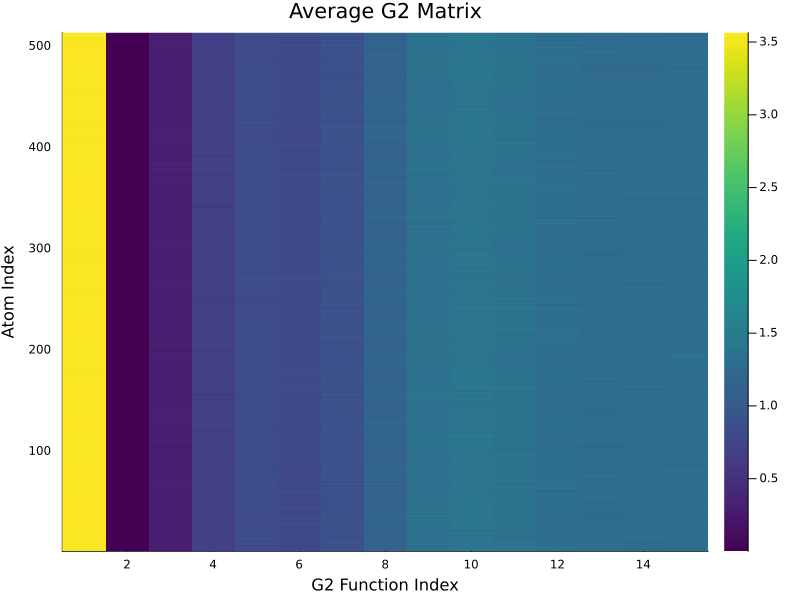

In [3]:
# Визуализация результатов
plot_g2_heatmap(avg_g2_mat)

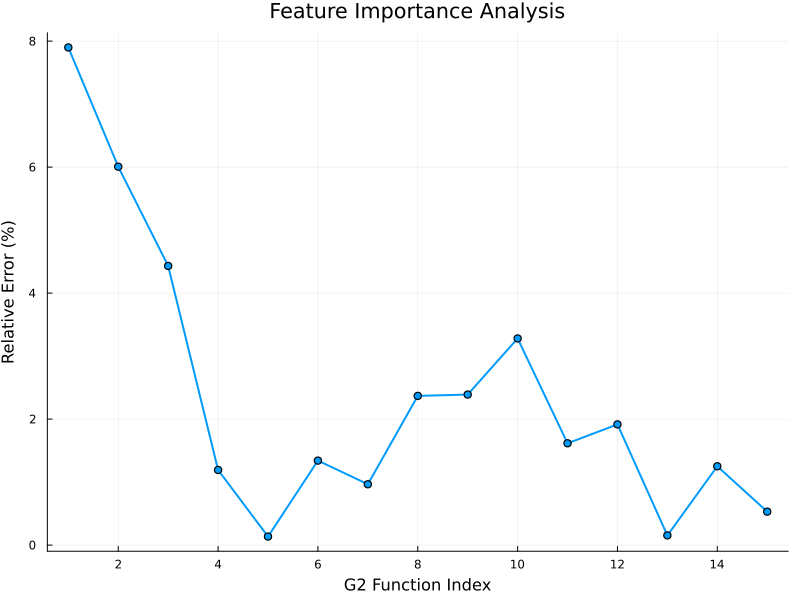

In [4]:
plot_feature_importance(feature_importance)

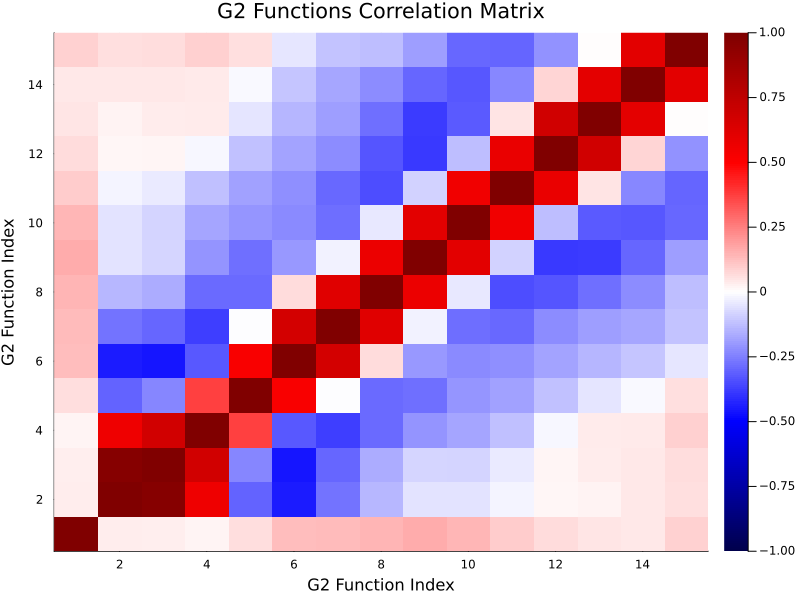

In [5]:
plot_correlation_matrix(cor_matrix)

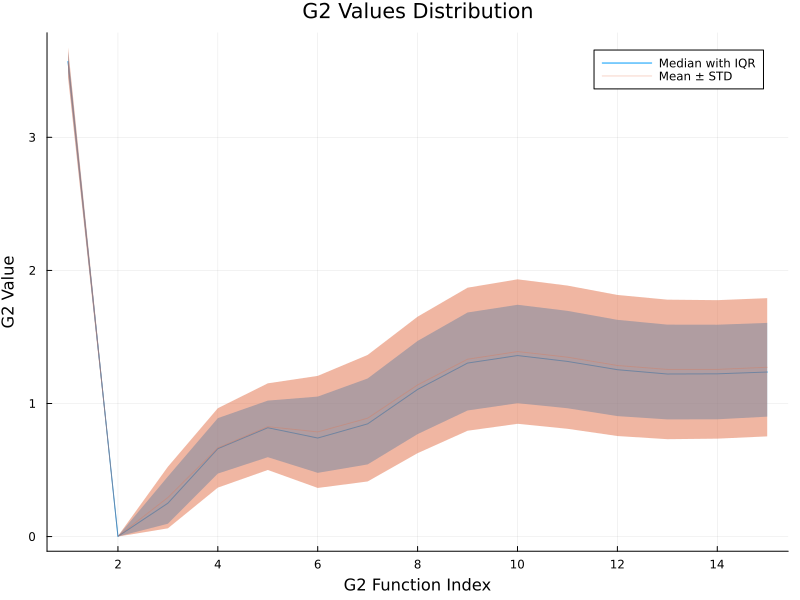

In [6]:
plot_g2_distribution(means, stds, quartiles)

# Concentration 10%

In [7]:
# Константы
MODEL_PATH = "model-iter-100.bson"
TRAJECTORY_PATH = "10CH3OH-CG-200.xtc"

"""
Список параметров G2 функций
"""
const G2_PARAMETERS = [
    G2(0.000, 15.0, 0.00, 11.525),
    G2(0.000, 3.60, 0.00, 11.525),
    G2(10.450, 15.0, 3.00, 1.678),
    G2(10.450, 15.0, 3.25, 1.678),
    G2(10.450, 15.0, 3.50, 1.678),
    G2(10.450, 15.0, 3.75, 1.678),
    G2(10.450, 15.0, 4.00, 1.678),
    G2(10.450, 15.0, 4.25, 1.678),
    G2(10.450, 15.0, 4.50, 1.678),
    G2(10.450, 15.0, 4.75, 1.678),
    G2(10.450, 15.0, 5.00, 1.678),
    G2(10.450, 15.0, 5.25, 1.678),
    G2(10.450, 15.0, 5.50, 1.678),
    G2(10.450, 15.0, 5.75, 1.678),
    G2(10.450, 15.0, 6.00, 1.678),
]

# Основной анализ

# Загрузка модели
@load MODEL_PATH model

# Вычисление G2 матриц
println("Computing G2 matrices...")
avg_g2_mat, all_g2_matrices = compute_average_g2_matrix(TRAJECTORY_PATH, G2_PARAMETERS)

# Вычисление среднего входного вектора
reference_input = vec(mean(avg_g2_mat, dims = 1))

# Анализ важности признаков
println("\nAnalyzing feature importance...")
feature_importance = analyze_feature_importance(model, reference_input)

# Анализ корреляций
println("\nAnalyzing G2 correlations...")
cor_matrix, strong_correlations = analyze_g2_correlations(avg_g2_mat)

# Анализ распределения
println("\nAnalyzing G2 distribution...")
means, stds, quartiles = analyze_g2_distribution(all_g2_matrices)

Computing G2 matrices...

Analyzing feature importance...


Feature: 1, Relative Error: 1.16%
Feature: 2, Relative Error: 0.61%
Feature: 3, Relative Error: 0.45%
Feature: 4, Relative Error: 0.13%
Feature: 5, Relative Error: 0.02%
Feature: 6, Relative Error: 0.26%
Feature: 7, Relative Error: 0.24%
Feature: 8, Relative Error: 0.61%
Feature: 9, Relative Error: 0.6%
Feature: 10, Relative Error: 0.8%
Feature: 11, Relative Error: 0.38%
Feature: 12, Relative Error: 0.43%
Feature: 13, Relative Error: 0.03%
Feature: 14, Relative Error: 0.25%
Feature: 15, Relative Error: 0.11%

Analyzing G2 correlations...

Сильно коррелирующие G2 функции (|r| > 0.9):
G2_2 - G2_3: r = 0.98

Analyzing G2 distribution...


([0.7082363077333965, 0.00022282870161561804, 0.02941966157053002, 0.0710186227263066, 0.10856174982466549, 0.1507960108243418, 0.21769533356898285, 0.2862529285140882, 0.3260605837283717, 0.33159437709449996, 0.3117000480410541, 0.28218272691140833, 0.2588565839278173, 0.24812650366774217, 0.248192106932809], [0.1600717075959169, 0.0007964001389390466, 0.09335257395380502, 0.16139298498666932, 0.19391990557327313, 0.21960393032239506, 0.2644725605850586, 0.3033716019121878, 0.32038024186623104, 0.32043570580378133, 0.3072351541926168, 0.2876383746666735, 0.27197345259675726, 0.26256217447935254, 0.25692517164368533], [0.5962043637521096 0.0 … 0.011800588739171478 0.014441147214573897; 0.7027959766023282 0.0 … 0.1770332406755729 0.1862409402816098; 0.8142139476137977 0.0 … 0.3996374706598824 0.38895624505167103])

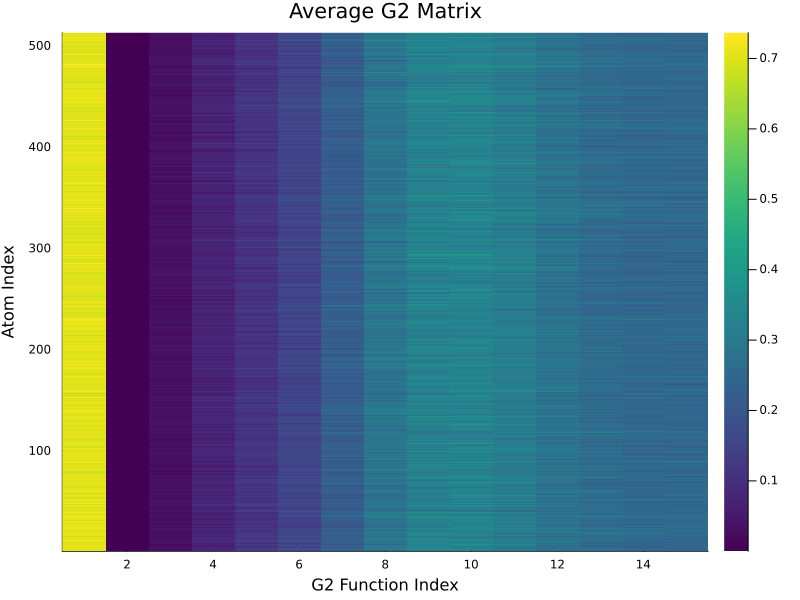

In [8]:
# Визуализация результатов
plot_g2_heatmap(avg_g2_mat)

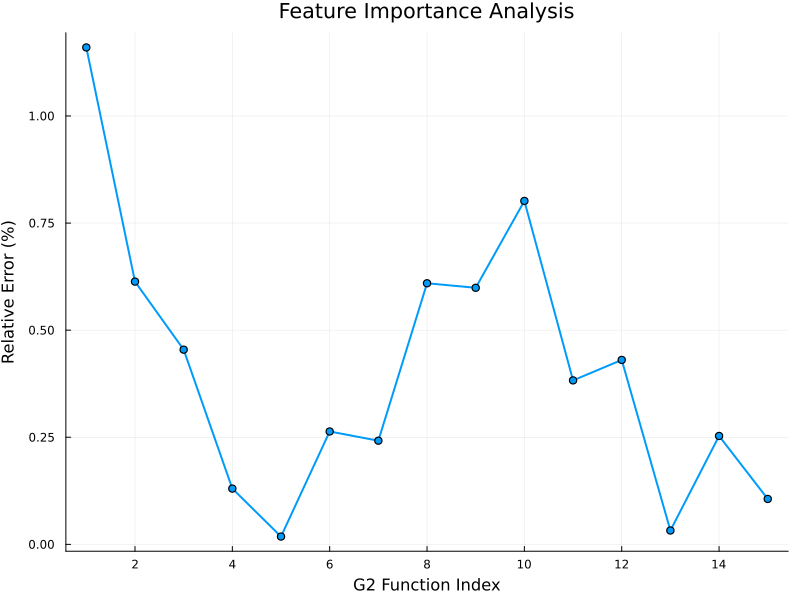

In [9]:
plot_feature_importance(feature_importance)

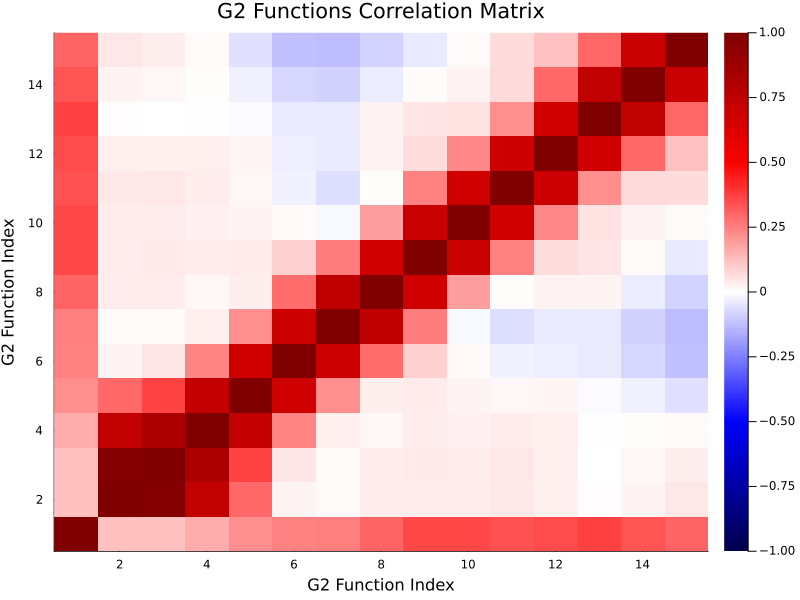

In [10]:
plot_correlation_matrix(cor_matrix)

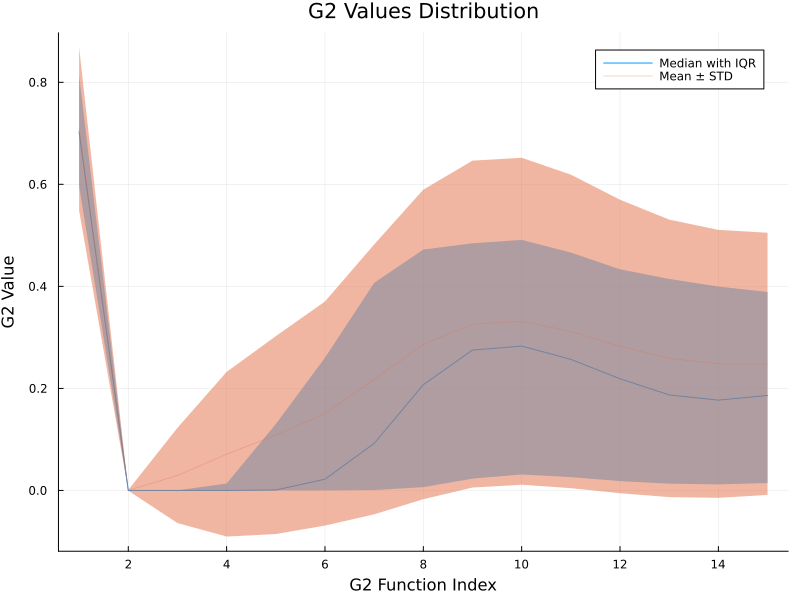

In [11]:
plot_g2_distribution(means, stds, quartiles)